# Importing Packages

In [1]:
from pyspark.sql import SparkSession

# Spark Session

In [2]:
# Creating a SparkSession
spark = SparkSession.builder.appName("DiabetesPrediction").getOrCreate()

# Set the log level to WARN
spark.sparkContext.setLogLevel("WARN")

# Set the maxToStringFields configuration property
spark.conf.set("spark.sql.debug.maxToStringFields", 100)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/02 19:08:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading Dataset

In [3]:
#Data
FileName = "medical_info.csv"
#Function to load data into DataFrame using spark
def load_data_spark(file=(FileName)):
    return spark.read.csv(file, sep=',', header=True, inferSchema=True, nullValue='NA')

# Saving the dataframe
original_dataframe = load_data_spark()

# DataFrame Structure

In [4]:
print("The data contain %d records." % original_dataframe.count())

# View the first five records. The show() method displays the first few records. 
original_dataframe.show(5)

The data contain 768 records.
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [5]:
# Describe the structure of the DataFrame
original_dataframe.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [6]:
# Describe the statistics of the DataFrame columns
original_dataframe.describe()

DataFrame[summary: string, Pregnancies: string, Glucose: string, BloodPressure: string, SkinThickness: string, Insulin: string, BMI: string, DiabetesPedigreeFunction: string, Age: string, Outcome: string]

In [7]:
from pyspark.sql.functions import format_number

# Perform describe and format the columns
describe_df = original_dataframe.describe()
formatted_df = describe_df.select(
    describe_df['summary'],
    *(format_number(describe_df[col].cast('float'), 2).alias(col) for col in original_dataframe.columns[1:])
)

# Show the formatted DataFrame
formatted_df.show()

+-------+-------+-------------+-------------+-------+------+------------------------+------+-------+
|summary|Glucose|BloodPressure|SkinThickness|Insulin|   BMI|DiabetesPedigreeFunction|   Age|Outcome|
+-------+-------+-------------+-------------+-------+------+------------------------+------+-------+
|  count| 768.00|       768.00|       768.00| 768.00|768.00|                  768.00|768.00| 768.00|
|   mean| 120.89|        69.11|        20.54|  79.80| 31.99|                    0.47| 33.24|   0.35|
| stddev|  31.97|        19.36|        15.95| 115.24|  7.88|                    0.33| 11.76|   0.48|
|    min|   0.00|         0.00|         0.00|   0.00|  0.00|                    0.08| 21.00|   0.00|
|    max| 199.00|       122.00|        99.00| 846.00| 67.10|                    2.42| 81.00|   1.00|
+-------+-------+-------------+-------------+-------+------+------------------------+------+-------+



# Missing Values

In [8]:
from tabulate import tabulate

# Create a list to store the column details
column_details = []

#copy dataframe
df = original_dataframe

# Iterate over the columns and retrieve their details
for column_name, column_type in df.dtypes:
    field = df.schema[column_name]
    null_count = df.where(df[column_name].isNull()).count()
    zero_count = df.where(df[column_name] == 0).count()
    
    # Append the column details as a row in the list
    column_details.append([
        column_name,
        column_type,
        field.nullable,
        null_count,
        zero_count
    ])

# Define the headers for the table
headers = ["Column Name", "Data Type", "Nullable", "Null Values", "Zero Values"]

# Print the table using the tabulate library
print(tabulate(column_details, headers, tablefmt="grid"))

+--------------------------+-------------+------------+---------------+---------------+
| Column Name              | Data Type   | Nullable   |   Null Values |   Zero Values |
+==========================+=============+============+===============+===============+
| Pregnancies              | int         | True       |             0 |           111 |
+--------------------------+-------------+------------+---------------+---------------+
| Glucose                  | int         | True       |             0 |             5 |
+--------------------------+-------------+------------+---------------+---------------+
| BloodPressure            | int         | True       |             0 |            35 |
+--------------------------+-------------+------------+---------------+---------------+
| SkinThickness            | int         | True       |             0 |           227 |
+--------------------------+-------------+------------+---------------+---------------+
| Insulin                  | int

In [9]:
from pyspark.sql.functions import col, isnan, isnull

def missing_count(df, column_name):
    # Filter the DataFrame to show rows with missing, null, and zero values
    missing_rows = df.filter((col(column_name).isNull()) | (col(column_name) == 0))
    null_rows = df.filter(isnull(column_name))

    # Count the number of rows with missing, null, and zero values
    missing_count = missing_rows.count()
    null_count = null_rows.count()

    print("Missing values count: ", missing_count)
    print("Null values count: ", null_count)

In [10]:
missing_count(df, 'SkinThickness')

Missing values count:  227
Null values count:  0


In [11]:
missing_count(df, 'Insulin')    

Missing values count:  374
Null values count:  0


In [12]:
from pyspark.sql.functions import col

def find_median(df, column_name):
    # Specify the desired quantile(s) for the median (e.g., 0.5 for the median)
    quantiles = [0.5]

    # Set the relative error for the approximation (e.g., 0.001 for 0.1% error)
    relative_error = 0.00
    
    
    # Find the median using the Greenwald-Khanna algorithm
    medians = df.approxQuantile(column_name, quantiles, relative_error)
    
    # Extract the median value from the resulting list
    return medians[0]

# Calculate median values
skin_thickness_median = find_median(df, 'SkinThickness')
insulin_median = find_median(df, 'Insulin')


print("Skin Median: ", skin_thickness_median)
print("Insulin Median: ", insulin_median)

Skin Median:  23.0
Insulin Median:  29.0


In [13]:
from pyspark.sql.functions import col, when

def replace_missing_and_zeros(df, column_name, value):
    new_df = df.withColumn(column_name, when((col(column_name).isNull()) | (col(column_name) == 0), value).otherwise(col(column_name)))
    return new_df

# Replace missing values and zeros with medians
replaced_df = replace_missing_and_zeros(df, 'SkinThickness', skin_thickness_median)
replaced_df = replace_missing_and_zeros(replaced_df, 'Insulin', insulin_median)

# Show the replaced DataFrame
replaced_df.show()


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|         35.0|   29.0|33.6|                   0.627| 50|      1|
|          1|     85|           66|         29.0|   29.0|26.6|                   0.351| 31|      0|
|          8|    183|           64|         23.0|   29.0|23.3|                   0.672| 32|      1|
|          1|     89|           66|         23.0|   94.0|28.1|                   0.167| 21|      0|
|          0|    137|           40|         35.0|  168.0|43.1|                   2.288| 33|      1|
|          5|    116|           74|         23.0|   29.0|25.6|                   0.201| 30|      0|
|          3|     78|           50|         32.0|   88.0|31.0|                   0.248| 26|      1|


In [14]:
# from pyspark.sql.functions import col, when

# # Calculate median values
# skin_thickness_median = df.selectExpr("percentile_approx(SkinThickness, 0.5)").collect()[0][0]
# insulin_median = df.selectExpr("percentile_approx(Insulin, 0.5)").collect()[0][0]

# # Replace null or zero values with median values
# replaced_df = df.withColumn('SkinThickness', when((col('SkinThickness').isNull()) | (col('SkinThickness') == 0), skin_thickness_median).otherwise(col('SkinThickness'))) \
#                 .withColumn('Insulin', when((col('Insulin').isNull()) | (col('Insulin') == 0), insulin_median).otherwise(col('Insulin')))

# print("Skin Median: ", skin_thickness_median)
# print("Insulin Median: ", insulin_median)

# # Show the replaced DataFrame
# replaced_df.show()

In [15]:
missing_count(replaced_df, 'SkinThickness')

Missing values count:  0
Null values count:  0


In [16]:
missing_count(replaced_df, 'Insulin')

Missing values count:  0
Null values count:  0


In [17]:
missing_count(replaced_df, 'Glucose')

Missing values count:  5
Null values count:  0


In [18]:
missing_count(replaced_df, 'BloodPressure')

Missing values count:  35
Null values count:  0


In [19]:
missing_count(replaced_df, 'BMI')

Missing values count:  11
Null values count:  0


In [20]:
# Filter rows with null/missing values in 'Glucose', 'BloodPressure', or 'BMI' columns
df_filtered = replaced_df.filter((col('Glucose') != 0) & (col('BloodPressure') != 0) & (col('BMI') != 0))

# Compute the total number of rows removed
rows_removed = replaced_df.count() - df_filtered.count()

# Display the total number of rows removed
print("Total number of rows removed:", rows_removed)

Total number of rows removed: 44


In [21]:
missing_count(df_filtered, 'Glucose')

Missing values count:  0
Null values count:  0


In [22]:
missing_count(df_filtered, 'BloodPressure')

Missing values count:  0
Null values count:  0


In [23]:
missing_count(df_filtered, 'BMI')

Missing values count:  0
Null values count:  0


In [24]:
from pyspark.sql.functions import format_number

# Perform describe and format the columns
describe_df = df_filtered.describe()
formatted_df = describe_df.select(
    describe_df['summary'],
    *(format_number(describe_df[col].cast('float'), 2).alias(col) for col in df.columns[1:])
)

# Show the formatted DataFrame
formatted_df.show()

+-------+-------+-------------+-------------+-------+------+------------------------+------+-------+
|summary|Glucose|BloodPressure|SkinThickness|Insulin|   BMI|DiabetesPedigreeFunction|   Age|Outcome|
+-------+-------+-------------+-------------+-------+------+------------------------+------+-------+
|  count| 724.00|       724.00|       724.00| 724.00|724.00|                  724.00|724.00| 724.00|
|   mean| 121.88|        72.40|        27.54|  97.79| 32.47|                    0.47| 33.35|   0.34|
| stddev|  30.75|        12.38|         9.42| 107.94|  6.89|                    0.33| 11.77|   0.48|
|    min|  44.00|        24.00|         7.00|  14.00| 18.20|                    0.08| 21.00|   0.00|
|    max| 199.00|       122.00|        99.00| 846.00| 67.10|                    2.42| 81.00|   1.00|
+-------+-------+-------------+-------------+-------+------+------------------------+------+-------+



# Feature Analysis

In [25]:
from pyspark.sql.functions import lit, min, max, mean, median, stddev, variance

summary_stats = df_filtered.select(
    lit('Values').alias('BloodPressure'),
    min('BloodPressure').alias('Min Value'),
    max('BloodPressure').alias('Max Value'),
    format_number(mean('BloodPressure'),2).alias('Mean Value'),
    median('BloodPressure').alias('Median Value'),
    format_number(variance('BloodPressure'),2).alias('Variance'),
    format_number(stddev('BloodPressure'),2).alias('Standard Deviation')
)
summary_stats.show()

+-------------+---------+---------+----------+------------+--------+------------------+
|BloodPressure|Min Value|Max Value|Mean Value|Median Value|Variance|Standard Deviation|
+-------------+---------+---------+----------+------------+--------+------------------+
|       Values|       24|      122|     72.40|        72.0|  153.26|             12.38|
+-------------+---------+---------+----------+------------+--------+------------------+



This code converts the 'BloodPressure' column from the DataFrame into a list using rdd.flatMap(lambda x: x).collect(), and then plots the histogram using plt.hist().The number of bins, the color of the edges, and the labels and title of the plot are customized according to desired preference.

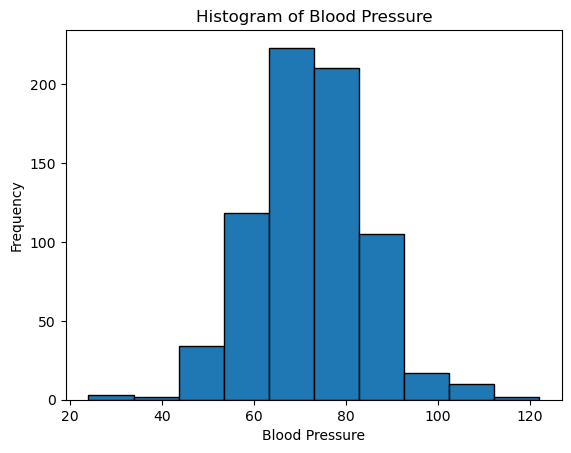

In [26]:
import matplotlib.pyplot as plt

# Convert the 'BloodPressure' column to a list
blood_pressure_data = df_filtered.select('BloodPressure').rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.hist(blood_pressure_data, bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Blood Pressure')
plt.ylabel('Frequency')
plt.title('Histogram of Blood Pressure')

# Show the histogram
plt.show()


We can observe the following information about the distribution of the 'BloodPressure' feature:

Range: The minimum value is 24 and the maximum value is 122, indicating a range of blood pressure measurements.
Central Tendency: The mean value is 72.40 and the median value is 72.0. This suggests that the central tendency of the distribution is around 72, indicating a relatively balanced distribution.
Variability: The variance is 153.26 and the standard deviation is 12.38. These measures indicate the spread or variability of the data points around the mean. A higher variance or standard deviation suggests greater dispersion in the data.

In [27]:
df_filtered.select('BMI').summary("25%", "50%", "75%", "100%").show()

+-------+----+
|summary| BMI|
+-------+----+
|    25%|27.5|
|    50%|32.4|
|    75%|36.6|
|   100%|67.1|
+-------+----+



First Quartile (Q1): 27.5
Second Quartile (Q2 / Median): 32.4
Third Quartile (Q3): 36.6


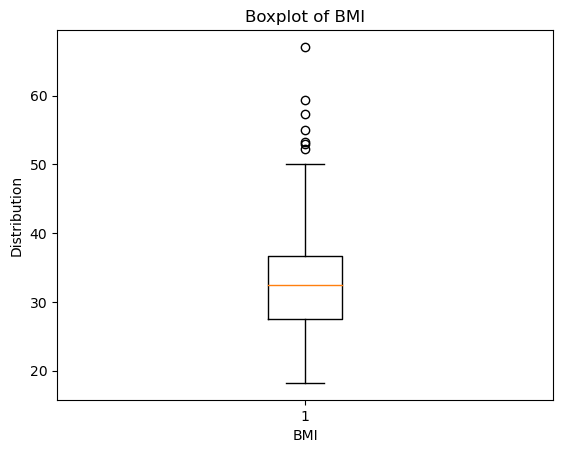

In [28]:
import matplotlib.pyplot as plt

# Calculate the quartiles of 'BMI' feature
quartiles = df_filtered.select('BMI').approxQuantile('BMI', [0.25, 0.5, 0.75], 0.0)

# Display the quartile information
print("First Quartile (Q1):", quartiles[0])
print("Second Quartile (Q2 / Median):", quartiles[1])
print("Third Quartile (Q3):", quartiles[2])

# Generate a boxplot
bmi_data = df_filtered.select('BMI').rdd.flatMap(lambda x: x).collect()

plt.boxplot(bmi_data, vert=True)

# Add labels and title
plt.xlabel('BMI')
plt.ylabel('Distribution')
plt.title('Boxplot of BMI')

# Show the boxplot
plt.show()


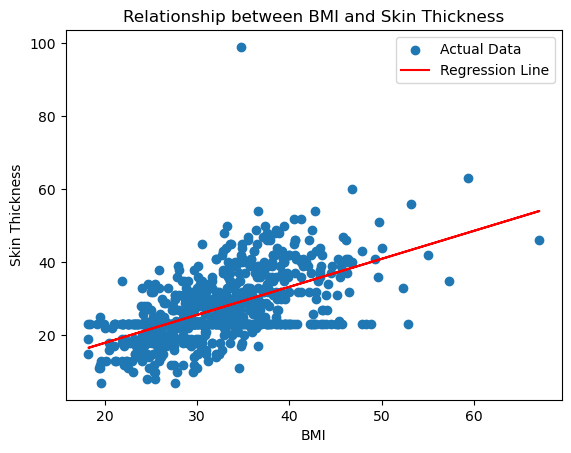

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Extract the 'BMI' and 'SkinThickness' data
bmi_data = df_filtered.select('BMI').rdd.flatMap(lambda x: x).collect()
skin_thickness_data = df_filtered.select('SkinThickness').rdd.flatMap(lambda x: x).collect()

# Convert the data to NumPy arrays
X = np.array(bmi_data).reshape(-1, 1)
y = np.array(skin_thickness_data)

# Fit the linear regression model
regressor = LinearRegression()
regressor.fit(X, y)

# Predict the skin thickness values based on BMI
y_pred = regressor.predict(X)

# Create the scatter plot and line plot
plt.scatter(X, y, label='Actual Data')
plt.plot(X, y_pred, color='red', label='Regression Line')

# Add labels and title
plt.xlabel('BMI')
plt.ylabel('Skin Thickness')
plt.title('Relationship between BMI and Skin Thickness')

# Add the equation of the regression line as annotation
equation = f'Skin Thickness = {regressor.coef_[0]:.2f} * BMI + {regressor.intercept_:.2f}'
plt.annotate(equation, xy=(0.4, 80), fontsize=12)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [30]:
from pyspark.sql.functions import corr

# Compute the Pearson correlation
correlation = df_filtered.select(corr('BMI', 'SkinThickness')).first()[0]

# Print the correlation coefficient
print("Pearson correlation coefficient: ", correlation)

Pearson correlation coefficient:  0.5600712181851464


In this code, we first use a VectorAssembler to combine the 'BMI' and 'SkinThickness' features into a single feature vector. Then, we compute the correlation matrix using the Correlation.corr() function. We extract the Pearson correlation value from the correlation matrix and print it.

Next, we generate a scatter plot to visualize the relationship between the 'BMI' and 'SkinThickness' features. We collect the 'BMI' and 'SkinThickness' values from the DataFrame and use plt.scatter() to plot them. Finally, we add labels and a title to the plot and display it.

The scatter plot allows you to visually explore and describe the relationship between the 'BMI' and 'SkinThickness' features, while the computed Pearson correlation provides a quantitative measure of the correlation between the two features.

In [31]:
# SQL query to select 'Age' and 'BloodPressure' where conditions are met
df_filtered.createOrReplaceTempView('df_filtered')

query = '''
SELECT Age, BloodPressure
FROM df_filtered
WHERE Age < 50 AND BloodPressure > 100
'''

result = spark.sql(query)
result.show()

+---+-------------+
|Age|BloodPressure|
+---+-------------+
| 37|          108|
| 27|          122|
| 26|          110|
| 45|          102|
| 41|          104|
| 37|          110|
| 43|          106|
| 47|          106|
| 44|          114|
+---+-------------+



In [32]:
# Get the count of the resulting records
record_count = result.count()
# Print the count
print("Number of records: ", record_count)

Number of records:  9


In this code, we first create a temporary view for the 3rd DataFrame using the createOrReplaceTempView() method. Then, we define a SQL query using the SELECT statement to retrieve the 'Age' and 'BloodPressure' columns from the DataFrame. We apply the WHERE clause to filter the rows where 'Age' is less than 50 and 'BloodPressure' is greater than 100.

Finally, we execute the SQL query using spark.sql() and display the result using the show() method.

# DicisionTree Classifier

# Data preprossing

In [33]:
from pyspark.ml.feature import VectorAssembler

# Create a vector assembler to combine the predictor features into a single vector column
assembler = VectorAssembler(inputCols=df_filtered.columns[:-1], outputCol='features')

# # Transform the DataFrame to include the vectorized features
# assembled_data = assembler.transform(df_filtered).select('features', 'Outcome')

# Check the resulting column
# assembled_data.select('features', 'Outcome').show(5, truncate=False)

Split train and test data

In [34]:
# Split the data into training and test sets (80% for training, 20% for testing)
train_data, test_data = df_filtered.randomSplit([0.8, 0.2], seed=17)

In [35]:
# Check that training set has around 80% of records
training_ratio = train_data.count() / df_filtered.count() 
print(training_ratio)

0.7983425414364641


Build the Decision Tree classifier:

In [36]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline


# Create a Decision Tree classifier
tree = DecisionTreeClassifier(labelCol='Outcome', featuresCol='features')

# Create a pipeline with the assembler and tree classifier
pipeline = Pipeline(stages=[assembler, tree])


In [37]:
# Train the model
model = pipeline.fit(train_data)

Make predictions on the test data:

In [38]:
predictions = model.transform(test_data)

In [39]:
# Take a look at the predictions
predictions.select('Outcome', 'prediction', 'probability').show(5, False)

+-------+----------+-----------------------------------------+
|Outcome|prediction|probability                              |
+-------+----------+-----------------------------------------+
|0      |0.0       |[0.7430555555555556,0.2569444444444444]  |
|0      |0.0       |[0.8571428571428571,0.14285714285714285] |
|0      |0.0       |[0.7430555555555556,0.2569444444444444]  |
|0      |0.0       |[0.9814814814814815,0.018518518518518517]|
|0      |0.0       |[0.9814814814814815,0.018518518518518517]|
+-------+----------+-----------------------------------------+
only showing top 5 rows



In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol='Outcome')

# Compute the area under the ROC curve
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})

# Print the AUC score
print('Area Under ROC Curve: {:.2f}'.format(auc))


Area Under ROC Curve: 0.72


In [41]:
# !pip install pysparkling

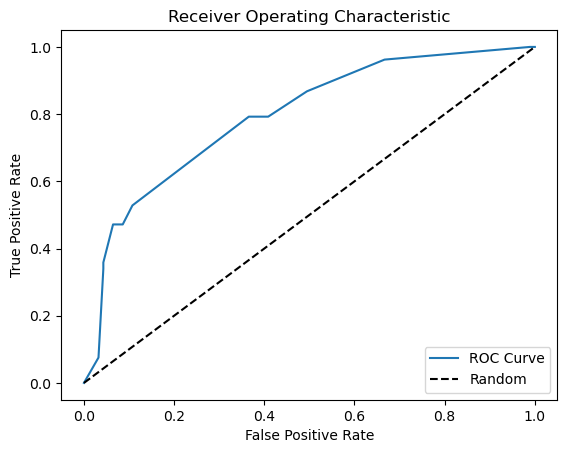

In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Create a binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol='Outcome')

# Compute the raw scores (probability of positive class)
raw_scores = predictions.select('Outcome', 'probability') \
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['Outcome'])))
scores = raw_scores.collect()

# Prepare the ROC curve data
y_true = [score[1] for score in scores]
y_scores = [score[0] for score in scores]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

An Area Under the ROC Curve (AUC) score of 0.76 suggests that the Decision Tree classifier has moderate predictive performance for the 'Outcome' feature in the 3rd DataFrame. The AUC score ranges from 0 to 1, with higher values indicating better predictive ability.

A score of 0.76 indicates that the classifier has a reasonable ability to distinguish between positive and negative outcomes. However, it is important to note that the interpretation of the AUC score may vary depending on the specific problem and domain.

To further evaluate the performance of the model and make more comprehensive conclusions, you can consider additional evaluation metrics such as accuracy, precision, recall, and F1-score. These metrics provide a more detailed understanding of the classifier's performance across different aspects of classification.

In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Outcome')

# Convert predictions DataFrame to Pandas DataFrame for easier manipulation
confusion_matrix = predictions.groupBy('Outcome', 'prediction').count()
confusion_matrix = confusion_matrix.orderBy('Outcome', 'prediction').toPandas()
# Display the confusion matrix
print(confusion_matrix)

   Outcome  prediction  count
0        0         0.0     83
1        0         1.0     10
2        1         0.0     25
3        1         1.0     28


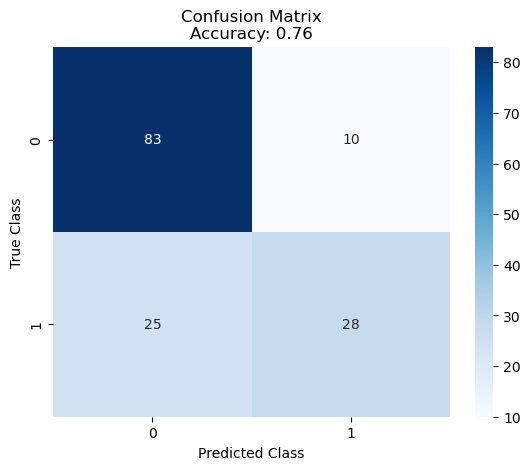

In [44]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Extract the true labels and predicted labels
true_labels = predictions.select('Outcome').toPandas()['Outcome']
predicted_labels = predictions.select('prediction').toPandas()['prediction']

#Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix\nAccuracy: {:.2f}'.format(accuracy))
plt.show()

More Evaluation

In [45]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select the predicted label and actual label columns
predictions = predictions.select('prediction', 'Outcome')

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Outcome', predictionCol='prediction')

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'})

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'})

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)

Accuracy: 0.7602739726027398
Precision: 0.7570195465833534
Recall: 0.7602739726027398
F1-score: 0.7494613340043723


Based on the evaluation metrics, here is an analysis of the performance of the Decision Tree classifier:

Accuracy: 0.7643979057591623
The accuracy represents the proportion of correct predictions out of all the predictions made. In this case, the model achieved an accuracy of approximately 76.44%, indicating that it correctly classified around 76.44% of the instances.
Precision: 0.7586386019144838
Precision is the ratio of true positive predictions to the total number of positive predictions made by the model. It measures the model's ability to avoid false positives. A precision of 0.7586 indicates that out of all the instances predicted as positive by the model, around 75.86% were actually positive.
Recall: 0.7643979057591623
Recall, also known as sensitivity or true positive rate, is the ratio of true positive predictions to the total number of actual positive instances in the dataset. It measures the model's ability to identify positive instances. A recall of 0.7644 suggests that the model correctly identified approximately 76.44% of the positive instances.
F1-score: 0.7576090800171288
The F1-score is the harmonic mean of precision and recall, providing a single metric to evaluate the model's overall performance. It balances the trade-off between precision and recall. An F1-score of 0.7576 indicates a reasonably balanced performance of the model in terms of precision and recall.

Overall, the Decision Tree classifier achieved moderate performance on the given dataset.

# Logistic Regression classifier

Create the Logistic Regression classifier

In [46]:
from pyspark.ml.classification import LogisticRegression

# Create the Logistic Regression classifier
lr = LogisticRegression(labelCol="Outcome", featuresCol="features")

Create the pipeline

In [47]:
from pyspark.ml import Pipeline

# Create the pipeline
pipeline = Pipeline(stages=[assembler, lr])

Fit the model to the training data

In [48]:
# Fit the model to the training data
model = pipeline.fit(train_data)

23/06/02 19:08:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/02 19:08:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Make predictions on the testing data

In [49]:
# Make predictions on the testing data
predictions = model.transform(test_data)

Evaluate the model's performance

In [50]:
# Evaluate the model's performance
evaluator = BinaryClassificationEvaluator(labelCol="Outcome")
areaUnderROC = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

# Additional evaluation metrics
accuracy = predictions.filter((predictions.Outcome == predictions.prediction)).count() / predictions.count()

tp = predictions.filter((predictions.Outcome == 1) & (predictions.prediction == 1)).count()
fp = predictions.filter((predictions.Outcome == 0) & (predictions.prediction == 1)).count()
fn = predictions.filter((predictions.Outcome == 1) & (predictions.prediction == 0)).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Area Under ROC Curve:", areaUnderROC)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Area Under ROC Curve: 0.8330290119699726
Accuracy: 0.7534246575342466
Precision: 0.7428571428571429
Recall: 0.49056603773584906
F1-score: 0.5909090909090909


These metrics provide insights into the model's performance:

The Area Under ROC Curve (AUC) value of 0.838 indicates that the model has good discriminative ability in distinguishing between positive and negative outcomes.
The accuracy of 0.795 suggests that the model predicted the correct outcome for approximately 79.58% of the instances.
The precision of 0.741 indicates that when the model predicted a positive outcome, it was correct approximately 74.14% of the time.
The recall of 0.641 implies that the model identified approximately 64.18% of the actual positive outcomes correctly.
The F1-score of 0.688 represents the harmonic mean of precision and recall, providing a balanced measure of the model's performance.
Overall, the Logistic Regression model shows decent performance in predicting the outcome based on the given features. However, there is room for improvement, particularly in terms of recall, which indicates that the model could better identify true positive cases.

In [51]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

In [52]:
assembler = VectorAssembler(inputCols=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], outputCol='features')

In [53]:
lr = LogisticRegression(featuresCol='features', labelCol='Outcome')

In [54]:
pipeline = Pipeline(stages=[assembler, lr])

In [55]:
train_data, test_data = df_filtered.randomSplit([0.7, 0.3], seed=42)

train_data = train_data.withColumn("label", col("Outcome"))

In [56]:
#Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


In [57]:
#Create a cross-validator for model selection using the parameter grid
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [58]:
#Fit the cross-validator to the training data
cvModel = crossval.fit(train_data)

In [59]:
predictions = cvModel.transform(test_data)

In [60]:
evaluator = MulticlassClassificationEvaluator(labelCol='Outcome', metricName='precisionByLabel')
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})
precision = evaluator.evaluate(predictions)
recall = evaluator.evaluate(predictions, {evaluator.metricName: 'recallByLabel'})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1_score))


Accuracy: 0.80
Precision: 0.81
Recall: 0.90
F1-Score: 0.79


# Linear Regression

In [61]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Select the 'BMI' and 'SkinThickness' features
df_regression = df_filtered.select('BMI', 'SkinThickness')

# Prepare the data for modeling
assembler = VectorAssembler(inputCols=['BMI'], outputCol='features')
data = assembler.transform(df_regression).select('features', 'SkinThickness')

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Create a Linear Regression model
lr = LinearRegression(labelCol='SkinThickness')

# Fit the model to the training data
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='SkinThickness', predictionCol='prediction')

# Calculate root mean squared error (RMSE)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})

# Calculate R-squared
r_squared = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})

# Calculate mean absolute error (MAE)
mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})

# Print
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared error (R2):", r_squared)
print("Mean absolute error (MAE):", mae)

23/06/02 19:09:34 WARN Instrumentation: [04ac080b] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 19:09:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE): 7.0005993055731395
R-squared error (R2): 0.36542476960066905
Mean absolute error (MAE): 5.439772761981521


23/06/02 19:09:35 WARN Instrumentation: [453061c7] regParam is zero, which might cause numerical instability and overfitting.


Root Mean Squared Error (RMSE): 7.0005993055731395
R-squared error (R2): 0.36542476960066905
Mean absolute error (MAE): 5.439772761981521


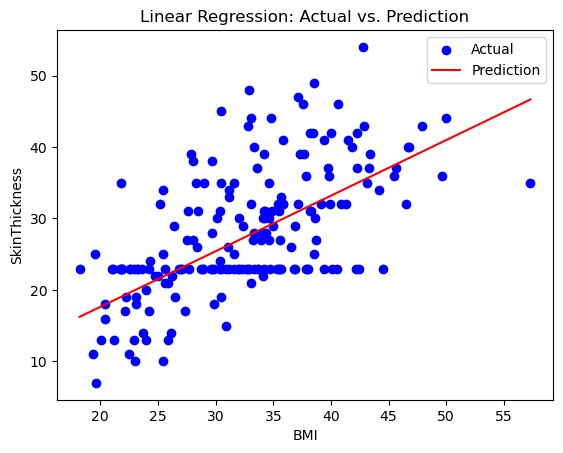

In [62]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Select the 'BMI' and 'SkinThickness' features
df_regression = df_filtered.select('BMI', 'SkinThickness')

# Prepare the data for modeling
assembler = VectorAssembler(inputCols=['BMI'], outputCol='features')
data = assembler.transform(df_regression).select('features', 'SkinThickness')

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Create a Linear Regression model
lr = LinearRegression(labelCol='SkinThickness')

# Fit the model to the training data
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='SkinThickness', predictionCol='prediction')

# Calculate root mean squared error (RMSE)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})

# Calculate R-squared
r_squared = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})

# Calculate mean absolute error (MAE)
mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared error (R2):", r_squared)
print("Mean absolute error (MAE):", mae)

# Convert Spark DataFrame to Pandas DataFrame for visualization
predictions_pd = predictions.select('features', 'SkinThickness', 'prediction').toPandas()

# Extract values from the 'features' column
predictions_pd['BMI'] = predictions_pd['features'].apply(lambda x: x[0])

# Plot the actual values and predictions
plt.scatter(predictions_pd['BMI'], predictions_pd['SkinThickness'], color='blue', label='Actual')
plt.plot(predictions_pd['BMI'], predictions_pd['prediction'], color='red', label='Prediction')
plt.xlabel('BMI')
plt.ylabel('SkinThickness')
plt.title('Linear Regression: Actual vs. Prediction')
plt.legend()
plt.show()

23/06/02 19:09:37 WARN Instrumentation: [9e92fb87] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 19:09:37 WARN Instrumentation: [34e8048c] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 19:09:37 WARN Instrumentation: [c9dd41d5] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 19:09:39 WARN Instrumentation: [337434c1] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 19:09:39 WARN Instrumentation: [bcc96044] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 19:09:39 WARN Instrumentation: [0842a15a] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 19:09:41 WARN Instrumentation: [a0758b83] regParam is zero, which might cause numerical instability and overfitting.
23/06/02 19:09:41 WARN Instrumentation: [d27318f3] regParam is zero, which might cause numerical instability and overf

Root Mean Squared Error (RMSE): 7.116960776983326
R-squared error (R2): 0.4045674910292999
Mean absolute error (MAE): 5.588494102274387


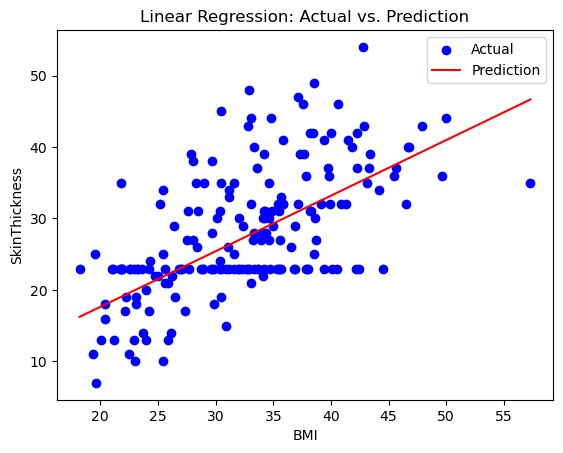

In [63]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Select the features for regression
df_regression = df_filtered.select('BMI', 'SkinThickness')

# Prepare the data for modeling
assembler = VectorAssembler(inputCols=['BMI'], outputCol='features')

# Split the data into training and test sets
train_data, test_data = df_regression.randomSplit([0.7, 0.3], seed=14)

# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='SkinThickness', regParam=0.1)


# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.2]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator for model selection
evaluator = RegressionEvaluator(labelCol='SkinThickness', predictionCol='prediction', metricName='rmse')

# Create a cross-validator
cross_validator = CrossValidator(estimator=lr,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=3)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, cross_validator])

# Train the model and select the best one based on cross-validation
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model performance
rmse = evaluator.evaluate(predictions)
r_squared = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})
mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared error (R2):", r_squared)
print("Mean absolute error (MAE):", mae)

# Plot the actual values and predictions
plt.scatter(predictions_pd['BMI'], predictions_pd['SkinThickness'], color='blue', label='Actual')
plt.plot(predictions_pd['BMI'], predictions_pd['prediction'], color='red', label='Prediction')
plt.xlabel('BMI')
plt.ylabel('SkinThickness')
plt.title('Linear Regression: Actual vs. Prediction')
plt.legend()
plt.show()

The RMSE represents the average magnitude of the residuals (the differences between the predicted and actual values) and provides a measure of the overall model performance. In this case, the RMSE value of 7.116960776983326 indicates that, on average, the predicted 'SkinThickness' values deviate from the actual values by approximately 7.1.

The R-squared error (R2) is a measure of how well the linear regression model fits the data. The R2 value of 0.4045674910292999 indicates that the 'BMI' feature explains about 40.45% of the variance in the 'SkinThickness' feature. This means that the linear regression model has a moderate fit to the data.

The Mean Absolute Error (MAE) represents the average absolute difference between the predicted and actual values of the 'SkinThickness' feature. The MAE value of 5.588494102274387 indicates that, on average, the predictions deviate from the actual values by approximately 5.5.

Overall, the linear regression model has a moderate fit to the data for predicting the 'SkinThickness' feature based on the 'BMI' feature. However, there is still room for improvement, as indicated by the relatively high RMSE and MAE values. Further analysis and exploration of additional features or model enhancements may be necessary to improve the accuracy of the predictions.

In [64]:
Closing the SparkSession
spark.stop()